<a href="https://colab.research.google.com/github/SJhawar1010/Reinforcement-Learning/blob/main/Satyam_554_RL_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Implementing Tracking in a Nonstationary Bandit Problem

**The Nonstationary Bandit Problem**

In the traditional multi-armed bandit problem, each arm (action) provides rewards from a stationary probability distribution. However, in many real-world scenarios, the reward distributions can change over time (nonstationary). This requires algorithms that not only explore and exploit but also track changes in the environment.

**Action-Value Methods**

In action-value methods, we estimate the value of each action based on the rewards received. In nonstationary problems, recent rewards are more indicative of the current value of an action than older rewards. Therefore, we can use a constant step-size parameter α to give more weight to recent rewards:

𝑄
𝑛
+
1
(
𝑎
)
=
𝑄
𝑛
(
𝑎
)
+
𝛼
[
𝑅
𝑛
−
𝑄
𝑛
(
𝑎
)
]
Q
n+1
​
 (a)=Q
n
​
 (a)+α[R
n
​
 −Q
n
​
 (a)]

**Where**:

𝑄
𝑛
(
𝑎
)
Q
n
​
 (a) is the estimated value of action
𝑎
a at time
𝑛
n.
𝑅
𝑛
R
n
​
  is the reward received after taking action
𝑎
a at time
𝑛
n.
𝛼
α is the step-size parameter (usually a small constant).

Alternatively, the sample-average method updates the action value based on the average of all observed rewards, which is not suitable for nonstationary problems as it gives equal weight to all past rewards.

**Importing Dependencies**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We will create a k-armed bandit where the true values of each arm change over time according to a random walk.

In [ ]:
class NonstationaryBandit:
    def __init__(self, k=10, q_mean=0, q_std=1, walk_std=0.01):
        self.k = k
        self.q_true = np.zeros(k) + q_mean
        self.q_std = q_std
        self.walk_std = walk_std
    def reset(self):
        self.q_true = np.zeros(self.k)
    def step(self, action):
        reward = np.random.randn() * self.q_std + self.q_true[action]
        self.q_true += np.random.randn(self.k) * self.walk_std
        return reward

**In the NonstationaryBandit class:**

- *q_true* represents the true action values of each arm, which change over time.

- Each time *step* is called, the true action values undergo a small random walk.

**Implementing Agents**

We will implement two agents:

- *Sample-Average Agent*: Uses the sample average of past rewards to estimate action values.

- *Constant Step-Size Agent*: Uses a constant step-size parameter α to update action values, which allows it to track changes.

In [ ]:
class Agent:
    def __init__(self, k, epsilon=0.1, initial=0):
        self.k = k
        self.epsilon = epsilon
        self.Q = np.zeros(k) + initial
        self.N = np.zeros(k)
    def select_action(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.k)
        else:
            return np.argmax(self.Q)
    def update(self, action, reward):
        pass
    def reset(self):
        self.Q = np.zeros(self.k)
        self.N = np.zeros(self.k)

**Sample-Average Agent Implementation**

In [ ]:
class SampleAverageAgent(Agent):
    def update(self, action, reward):
        self.N[action] += 1
        self.Q[action] += (1 / self.N[action]) * (reward - self.Q[action])

**Constant Step-Size Agent Implementation**

In [ ]:
class ConstantStepSizeAgent(Agent):
    def __init__(self, k, epsilon=0.1, alpha=0.1, initial=0):
        super().__init__(k, epsilon, initial)
        self.alpha = alpha
    def update(self, action, reward):
        self.Q[action] += self.alpha * (reward - self.Q[action])

**Running Experiments**

We will run simulations to compare the performance of the two agents.

In [ ]:
def simulate(bandit, agents, steps=1000, runs=2000):
    rewards = np.zeros((len(agents), runs, steps))
    optimal_actions = np.zeros_like(rewards)
    for i, agent in enumerate(agents):
        for r in range(runs):
            bandit.reset()
            agent.reset()
            optimal_action = np.argmax(bandit.q_true)
            for t in range(steps):
                action = agent.select_action()
                reward = bandit.step(action)
                agent.update(action, reward)
                rewards[i, r, t] = reward
                optimal_action = np.argmax(bandit.q_true)
                if action == optimal_action:
                    optimal_actions[i, r, t] = 1
    avg_rewards = rewards.mean(axis=1)
    avg_optimal_actions = optimal_actions.mean(axis=1) * 100
    return avg_rewards, avg_optimal_actions

In the *simulate* function:

- We run multiple simulations (*runs*), each for a number of time steps (*steps*).

- For each agent, we record the rewards and whether the agent selected the optimal action at each time step.

- We calculate the average reward and percentage of optimal actions over all runs.

**Comparing Agents**

Creating instances of our agents and compare their performance.

In [ ]:
k = 10
steps = 10000
runs = 2000
epsilon = 0.1
bandit = NonstationaryBandit(k=k)
agents = [
    SampleAverageAgent(k, epsilon=epsilon),
    ConstantStepSizeAgent(k, epsilon=epsilon, alpha=0.1)
]
labels = ['Sample Average', 'Constant Step-size α=0.1']
avg_rewards, avg_optimal_actions = simulate(bandit, agents, steps=steps, runs=runs)

####**Plotting Results**

**Cumulative Average Reward Over Time**

This plot shows how the average reward accumulates over time for each agent. It provides a sense of the overall performance and how quickly agents learn to maximize rewards.

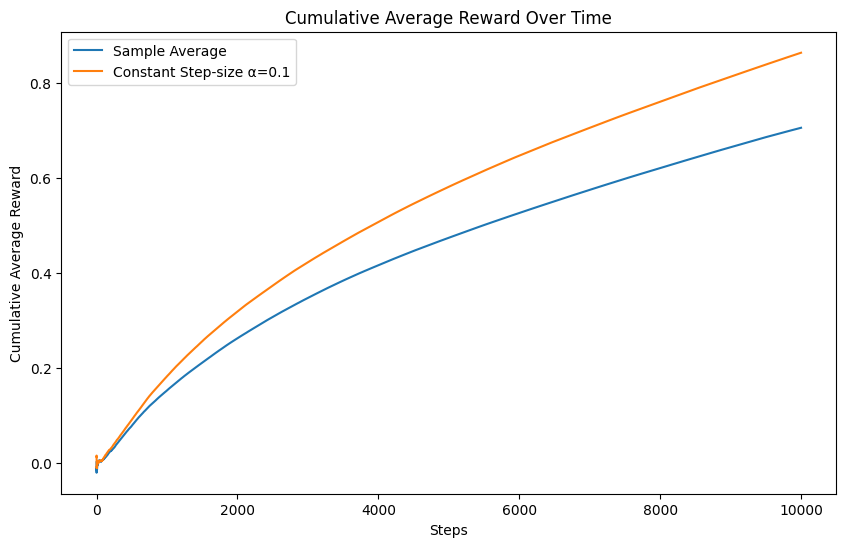

In [ ]:
plt.figure(figsize=(10, 6))
for i in range(len(agents)):
    cumulative_rewards = np.cumsum(avg_rewards[i]) / (np.arange(steps) + 1)
    plt.plot(cumulative_rewards, label=labels[i])
plt.xlabel('Steps')
plt.ylabel('Cumulative Average Reward')
plt.title('Cumulative Average Reward Over Time')
plt.legend()
plt.show()

**Regret Over Time**

Regret measures the difference between the reward that could have been obtained by always selecting the optimal action and the reward actually obtained by the agent. Lower regret indicates better performance.

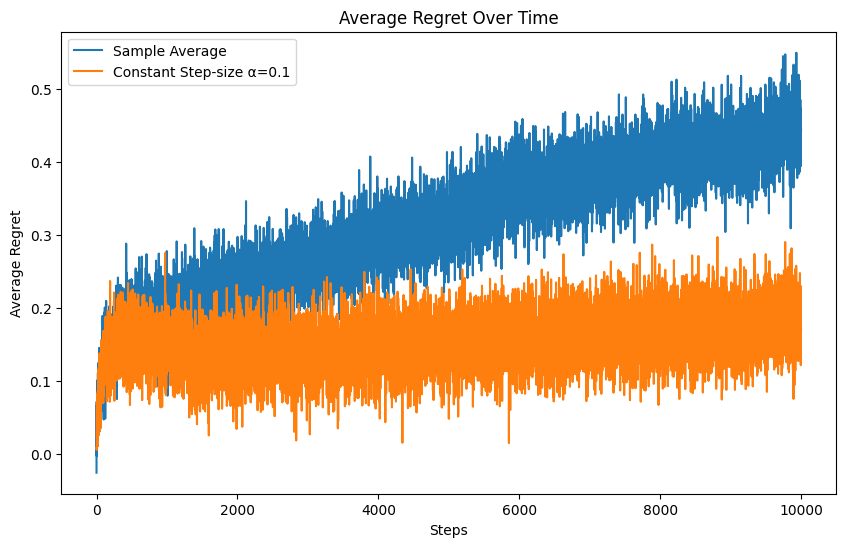

In [ ]:
def simulate_regret(bandit, agents, steps=1000, runs=2000):
    regrets = np.zeros((len(agents), runs, steps))
    for i, agent in enumerate(agents):
        for r in range(runs):
            bandit.reset()
            agent.reset()
            for t in range(steps):
                optimal_action = np.argmax(bandit.q_true)
                action = agent.select_action()
                reward = bandit.step(action)
                agent.update(action, reward)
                optimal_reward = np.random.randn() * bandit.q_std + bandit.q_true[optimal_action]
                regret = optimal_reward - reward
                regrets[i, r, t] = regret
    avg_regrets = regrets.mean(axis=1)
    return avg_regrets
avg_regrets = simulate_regret(bandit, agents, steps=steps, runs=runs)
plt.figure(figsize=(10, 6))
for i in range(len(agents)):
    plt.plot(avg_regrets[i], label=labels[i])
plt.xlabel('Steps')
plt.ylabel('Average Regret')
plt.title('Average Regret Over Time')
plt.legend()
plt.show()

**Estimated Q Values vs. True Q Values**

This plot compares the estimated action values (𝑄) with the true action values over time for each agent. It provides insight into how accurately agents track the true values of actions.

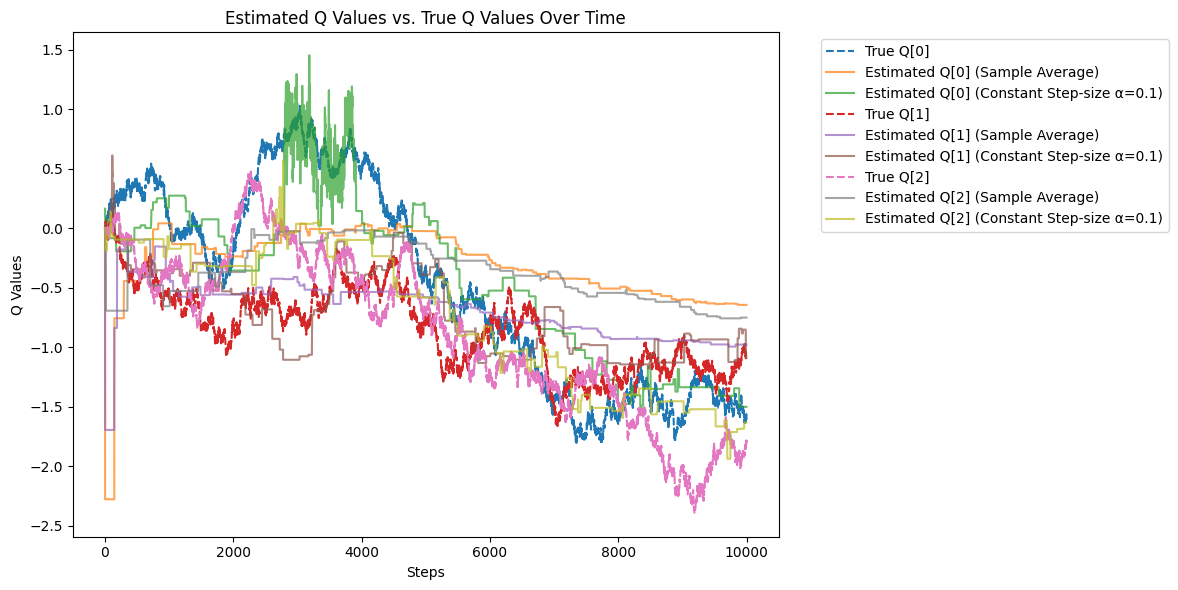

In [ ]:
single_run = 0
time_points = np.linspace(0, steps, num=1000, endpoint=False, dtype=int)
bandit.reset()
for agent in agents:
    agent.reset()
estimated_Q = {label: [] for label in labels}
true_Q = []
for t in range(steps):
    for label, agent in zip(labels, agents):
        action = agent.select_action()
        reward = bandit.step(action)
        agent.update(action, reward)
        estimated_Q[label].append(agent.Q.copy())
    true_Q.append(bandit.q_true.copy())
true_Q = np.array(true_Q)
for label in labels:
    estimated_Q[label] = np.array(estimated_Q[label])
plt.figure(figsize=(12, 6))
arms_to_plot = [0, 1, 2]
for arm in arms_to_plot:
    plt.plot(true_Q[:, arm], label=f'True Q[{arm}]', linestyle='--')
    for label in labels:
        plt.plot(estimated_Q[label][:, arm], label=f'Estimated Q[{arm}] ({label})', alpha=0.7)
plt.xlabel('Steps')
plt.ylabel('Q Values')
plt.title('Estimated Q Values vs. True Q Values Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Number of Times Each Action Was Selected**

This plot displays how frequently each action is selected by the agents over time. It helps in understanding the exploration-exploitation behavior of the agents.

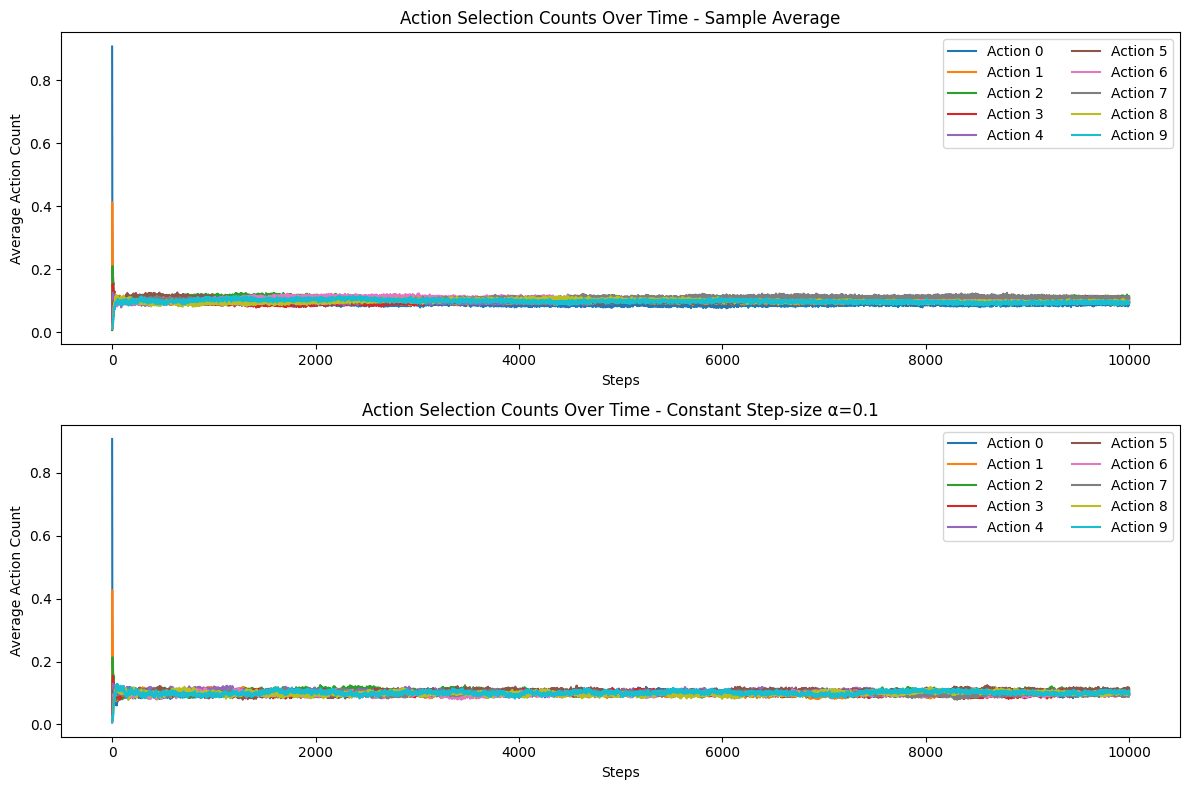

In [ ]:
def simulate_action_counts(bandit, agents, steps=1000, runs=2000):
    action_counts = np.zeros((len(agents), bandit.k, runs, steps))
    for i, agent in enumerate(agents):
        for r in range(runs):
            bandit.reset()
            agent.reset()
            for t in range(steps):
                action = agent.select_action()
                reward = bandit.step(action)
                agent.update(action, reward)

                action_counts[i, action, r, t] = 1
    avg_action_counts = action_counts.mean(axis=2)
    return avg_action_counts
avg_action_counts = simulate_action_counts(bandit, agents, steps=steps, runs=runs)
plt.figure(figsize=(12, 8))
for i, label in enumerate(labels):
    plt.subplot(len(agents), 1, i+1)
    for action in range(k):
        plt.plot(avg_action_counts[i, action], label=f'Action {action}')
    plt.xlabel('Steps')
    plt.ylabel('Average Action Count')
    plt.title(f'Action Selection Counts Over Time - {label}')
    plt.legend(loc='upper right', ncol=2)
plt.tight_layout()
plt.show()

**Average Reward v/s % Optimal Action**

This plot lots the average reward and percentage of optimal actions over time.

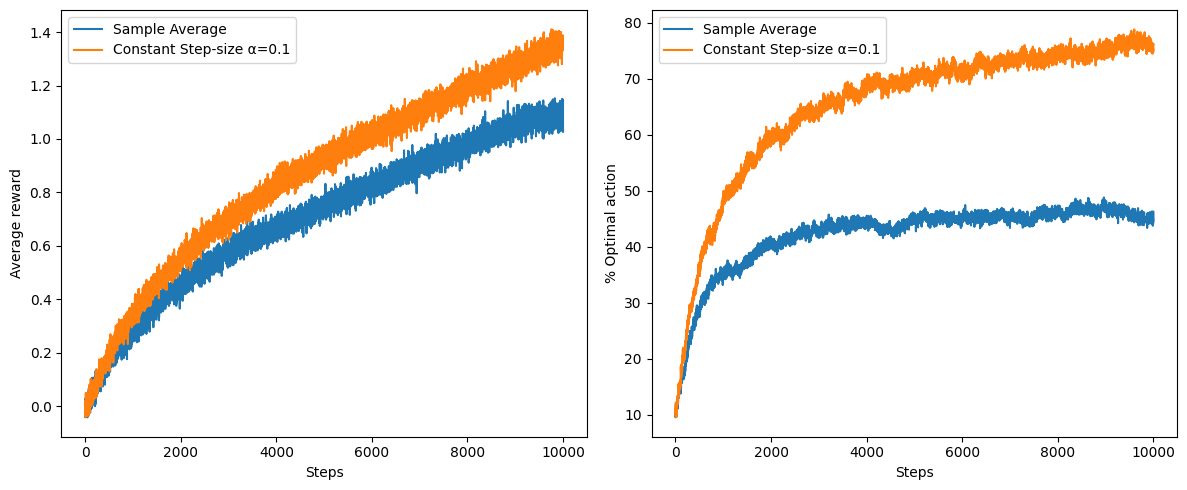

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(len(agents)):
    plt.plot(avg_rewards[i], label=labels[i])
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.legend()
plt.subplot(1, 2, 2)
for i in range(len(agents)):
    plt.plot(avg_optimal_actions[i], label=labels[i])
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.legend()
plt.tight_layout()
plt.show()

**Analysis**

From the plots, we can observe:

- *Sample-Average Agent*: Initially performs well but struggles to adapt to changes in the action values due to equal weighting of all past rewards.
- *Constant Step-Size Agent*: Performs better in the long run as it can adapt to changes by giving more weight to recent rewards.

**Inference**

In nonstationary environments, agents that can adapt to changes by emphasizing recent experiences outperform those that treat all past experiences equally. Using a constant step-size parameter allows the agent to track changes in the action values effectively.